# Import dependencies

In [1]:
!pip install keras

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install cython

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import sys
sys.path.append('Mask_RCNN')

In [4]:
import os
import sys
import random
import math
import re
import time
import gc; gc.enable()

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
#sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
import imageio
import skimage
from config import Config
from skimage.morphology import label
from skimage.feature import canny
from skimage import exposure
from keras.callbacks import Callback
from skimage.morphology import binary_closing, binary_opening, disk, binary_dilation
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.externals import joblib
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.morphology import watershed
from skimage.filters import sobel
from preparation import vgg_feature_extractor
from random import *

import gc; gc.enable()
import utils
import model as modellib
import visualize
from model import log

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Let's download the mask_rcnn trained on COCO dataset to initialize the model.

In [5]:
pd.options.display.max_rows=100

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

We will now define the monitor that will help keep track on the training process.
With this you will be able to see your charts in the `charts` tab

Now we will load the metadata and divide them in train and valid splits

In [6]:
TRAIN_PATH = '../stage1_train'
TEST_PATH = '../stage2_test_final'
META_DATA_PATH = '../stage2_metadata.csv'
BG_DATA_PATH = '../stage2_foreground_background_classes.csv'

In [7]:
if not os.path.exists(META_DATA_PATH):
    print('Generating stage1_metadata.csv')
    
    stage1_metadata = pd.DataFrame()
    
    train_image_ids = os.listdir(TRAIN_PATH) # ImageId
    train_is_train = [1] * len(train_image_ids)
    
    train_file_path = []
    for p in train_image_ids:
        if p[:4] == 'TCGA':
            train_file_path.append(TRAIN_PATH + '/' + p + '/images/' + p + '.tif')
        else:
            train_file_path.append(TRAIN_PATH + '/' + p + '/images/' + p + '.png')
    
    test_image_ids = os.listdir(TEST_PATH) # ImageId
    test_is_train = [0] * len(test_image_ids)
    test_file_path = [TEST_PATH + '/' + p + '/images/' + p + '.png' for p in test_image_ids]
    
    stage1_metadata['ImageId'] = np.concatenate([train_image_ids, test_image_ids], axis=0)
    stage1_metadata['is_train'] = np.concatenate([train_is_train, test_is_train], axis=0)
    stage1_metadata['file_path_image'] = np.concatenate([train_file_path, test_file_path], axis=0)
    
    ve = vgg_feature_extractor(n_clusters=10)
    train_vgg_features_clusters = ve.get_vgg_clusters(stage1_metadata[stage1_metadata.is_train == 1].reset_index(drop=True), is_train=True)
    test_vgg_features_clusters =ve.get_vgg_clusters(stage1_metadata[stage1_metadata.is_train == 0].reset_index(drop=True), is_train=False)
    
    stage1_metadata['vgg_features_clusters'] = np.concatenate([train_vgg_features_clusters, test_vgg_features_clusters], axis=0)
    
    stage1_metadata.to_csv(META_DATA_PATH, index=False)
    meta = stage1_metadata
    
    del vgg_feature_extractor; gc.collect()
else:
    meta = pd.read_csv(META_DATA_PATH)
    

meta.head(100)

,ImageId,is_train,file_path_image,vgg_features_clusters
0,ef6634efb46567d87b811be786b18c4cd0e2cda23d79b6...,1,../stage1_train/ef6634efb46567d87b811be786b18c...,1
1,351771edfc5db5665ded8aa4940257276b6526663c76e3...,1,../stage1_train/351771edfc5db5665ded8aa4940257...,6
2,785555c0cbb49dad835635217085287a8cc61c27d26f0e...,1,../stage1_train/785555c0cbb49dad83563521708528...,4
3,7ba20aa731cc21af74a8d940254176cbad1bdc44f240b5...,1,../stage1_train/7ba20aa731cc21af74a8d940254176...,1
4,43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1f...,1,../stage1_train/43cf6b2ec0b0745ac2b87b4d8780f6...,3
5,0b2e702f90aee4fff2bc6e4326308d50cf04701082e718...,1,../stage1_train/0b2e702f90aee4fff2bc6e4326308d...,4
6,61dc249314d7b965eb4561ec739eab9b0f60af55c97b25...,1,../stage1_train/61dc249314d7b965eb4561ec739eab...,6
7,28d33efef218392e79e385906deb88055d94b65ad217de...,1,../stage1_train/28d33efef218392e79e385906deb88...,0
8,4596961c789d3b41916492918797724fe75128239fefc5...,1,../stage1_train/4596961c789d3b4191649291879772...,6
9,1ec74a26e772966df764e063f1391109a60d803cff9d15...,1,../stage1_train/1ec74a26e772966df764e063f13911...,9


In [8]:
back_ground_df = pd.read_csv(BG_DATA_PATH)
back_ground_df.tail(100)

,ImageId,bg_type
2919,f712caa5d4ec696c143dee607100664f983820cee20b5a...,bw
2920,f749bd3d0801a25581ebdecb696f4883c13e2f44ae071a...,bw
2921,f7525279fa7d5896baf5dfb8b7535e0f4b5f19f2deed19...,bw
2922,f76ae9f189bdb18a7ce90ddc760388cef13785866c1610...,bw
2923,f77e0a7408802b56ad0d44915a882003dc048a8c04baf5...,bw
2924,f7a5c69c3908e4a7443722bc0a59f998afff7735ae63a8...,bw
2925,f7a6b7d515d1dc27915128663085998f978bdc5e9917f9...,bw
2926,f7ad1329e948e9a540af770c2af37c235144d014aae3a0...,bw
2927,f7c60564c8da0a484eb81b011f8fcc46c5749d20b012d0...,bw
2928,f7c7666bd0e4a6a3abc0be51479133df8f77d649203aa5...,bw


In [9]:
back_ground_df = back_ground_df.set_index('ImageId')
back_ground_df.head(10)

,bg_type
ImageId,
0019c086029dd3be01f72131edb74e21ee995574e6d5c136ea868630b0d73523,he
004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a75197dbb0be06da05cf,bw
005463e6d4a0a0b21161f1d97392f22556fbddba970d9440ae774229308a91ed,bw
005af293e8e53218ae96746ecf9bb88b511154d4a0b35e4ec6296b4623e15836,bw
005d47447abac7f7fa0ac56ba82f13edbf485105baf0672504d84b58d562f38b,bw
00ac87390253a22f6eb67c5771a73050e06200d1aa682fcf1b1e3783b2944166,bw
00b4b9c026cfc91af21691503bad67081fc02d5c77b3cd27200d02dca6966b83,bw
00da4fe5346bbb36ccf178964a22fdf7e33888989624176a6af3b4a7cfd7da63,bw
00e36f2470960e84cfc9f0d30c1f76abd7b35e4516380bf74985cbe641086806,bw


In [10]:
meta = meta[meta['is_train'] == 0].reset_index(drop=True)

In [11]:
meta['bg_type'] = meta.ImageId.map(back_ground_df.bg_type)

In [12]:
meta['process_type'] = meta['bg_type'].map({
    'bw': 2, # do nothing
    'wb': 3, # pure reverse
    'he': 2, # do nothing
    'c_bw': 0, # turns into gray 
    'c_wb': 1, # turns into gray and reverse
})
meta['process_type'].value_counts()

2    3016
1       2
3       1
Name: process_type, dtype: int64

In [13]:
meta['group'] = meta['bg_type'].map({
    'bw': 0, # do nothing
    'wb': 0, # pure reverse
    'he': 1, # do nothing
    'c_bw': 0, # turns into gray 
    'c_wb': 0, # turns into gray and reverse
})
meta['group'].value_counts()

0    2803
1     216
Name: group, dtype: int64

In [14]:
meta_test = meta

# Mask-RCNN configuration
We will now define parameters for our mask-rcnn. 
Tweak them to get better results!

In [15]:
class DsbConfig(Config):

    # Give the configuration a recognizable name
    NAME = "dsb"
      
    LEARNING_RATE = 1e-2
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution image
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    
    # Train on 1 GPU and 8 images per GPU. Batch size is GPUs * images/GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
    # typically be equal to the number of samples of your dataset divided by the batch size
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 70

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleis
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_PADDING = True  # currently, the False option is not supported
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels, maybe add a 256?
    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 320 #300
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14 # 14
    MASK_SHAPE = [28, 28] # 28
    TRAIN_ROIS_PER_IMAGE = 512
    RPN_DETECTION_MIN_CONFIDENCE = .6
    RPN_NMS_THRESHOLD = 0.6 #0.7
    MAX_GT_INSTANCES = 256
    DETECTION_MAX_INSTANCES = 450 
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.67 # may be smaller?
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3 # 0.3
    
    # DETECTION_MAX_INSTANCES=400, DETECTION_MIN_CONFIDENCE=.7 => Val loss: .21xx, LB: .424
    # DETECTION_MAX_INSTANCES=450, DETECTION_MIN_CONFIDENCE=.65 => Val loss: .3, LB: .438
    # DETECTION_MAX_INSTANCES=, DETECTION_MIN_CONFIDENCE= => Val loss: ., LB: .
    
    '''
    0324 note: 
        RPN_NMS_THRESHOLD .7 -> .6 to generate more proposals at training,
        DETECTION_MAX_INSTANCES 400 -> 450
        DETECTION_MIN_CONFIDENCE .7
        BACKBONE_STRIDES add `2` ..?
    '''
    
    MEAN_PIXEL = np.array([0.,0.,0.])
    
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    
    # Min Box Size
    MIN_BOX_SIZE = 36./(512.**2.) # (36/512**2) (delete objects smaller than 6*6 pixels)
    BORDER_RATIO = 4. / 512. # smaller than 4 pixels width\height at the border
    BORDER_MIN_BOX_SIZE = 16./(512.**2.)
  
    LR_SHRINK_PERIOD = 10
    
config = DsbConfig()

# Dataset definition

We need to define our datasets for the data science bowl competition

In [16]:
from augment import Augment

class DsbDataset(utils.Dataset):
    '''
    process_info is a image-id <=> process type mapping pd.series
    '''
    def load_dataset(self, process_info, train_mode=True, augment=False):
        self.add_class("dsb", 1, "nuclei")
        self.process_info = process_info
        self.augmenter = Augment()
        self.augment = augment
        
        if train_mode:
            directory = dsb_dir
        else:
            directory = test_dir
            
        ids = []
        for i, id in enumerate(process_info.ImageId.values):
            image_dir = os.path.join(directory, id)
            self.add_image("dsb", image_id=i, path=image_dir)
            ids.append(i)
        
        self.process_info.reset_index(drop=True, inplace=True)
        #print(self.process_info)
        self.process_info['id'] = ids
        self.process_info.set_index('id')
        self.process_info = self.process_info['process_type']
        #print(self.process_info)
        
    def load_image(self, image_id, non_zero=None):
        info = self.image_info[image_id]
        path = info['path']
        image_name = os.listdir(os.path.join(path, 'images'))
        image_path = os.path.join(path, 'images', image_name[0])
        image = imageio.imread(image_path)
        
        #print(self.process_info[image_id])
        if image_path[-4:] == '.tif':
            self.offset = (randrange(488), randrange(488))
            image = image[self.offset[0]:self.offset[0]+512, self.offset[1]:self.offset[1]+512, :]
            #image = skimage.transform.resize(image, (512,512),  preserve_range=True)
        
        try:
            if image.shape[2] != 3:
                image = image[:,:,:3]
        except:
            print(image)
            image = image / 255.
            image = skimage.color.gray2rgb(image.astype('uint8'))
            print('new\n', image)
            
        image = self.preprocess(image, process_type=self.process_info[image_id])
        image = image.astype('float32')
        
        if self.augment:
            self.augment_func = self.augmenter.get_random_augement()
            image = self.augment_func(image)
            
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        mask_dir = os.path.join(path, 'masks')
        mask_names = os.listdir(mask_dir)
        count = len(mask_names)
        mask = []
        
        for i, el in enumerate(mask_names):
            msk_path = os.path.join(mask_dir, el)
            msk = imageio.imread(msk_path)
            if np.sum(msk) == 0:
                print('invalid mask')
                continue
                
            if 'TCGA' in mask_dir:
                #msk = skimage.transform.resize(msk, (512,512), preserve_range=True)
                msk = msk[self.offset[0]:self.offset[0]+512, self.offset[1]:self.offset[1]+512]
                if np.sum(msk) == 0:
                    continue
                
            msk = msk.astype('float32')/255.
            
            if len(msk.shape) > 2:
                msk = np.sum(msk, axis=2)
                
            mask.append(msk)
            
        try:
            mask = np.array(mask)
        except:
            for i, m in enumerate(mask):
                if len(m.shape) > 2:
                    print(mask_names[i])
                    
        mask[mask > 0.] = 1.
        mask = np.transpose(mask, (1,2,0))
        if self.augment:
            mask = self.augment_func(mask) # self.augment_func was decided when loading image before loading masks
            
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        count = mask.shape[2]
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        class_ids = [self.class_names.index('nuclei') for s in range(count)]
        class_ids = np.asarray(class_ids)
        
        return mask, class_ids.astype(np.int32)
    
    def preprocess(self, img, process_type=0):
        if process_type == 0: # grey-rgb-grey
            gray = skimage.color.rgb2gray(img.astype('uint8'))
            img = skimage.color.gray2rgb(gray)
            img *= 255.
        elif process_type == 1:  # grey-rgb-grey-reverse
            gray = skimage.color.rgb2gray(img.astype('uint8'))
            img = skimage.color.gray2rgb(gray)
            img *= 255.
            img = 255. - img
        elif process_type == 2:
            img = img.astype(float) # do nothing
        elif process_type == 3:
            img = 255. - img
        
        return img

In [17]:
dsb_dir = TRAIN_PATH
test_dir = TEST_PATH

# Evaluate
I think we are ready to see how our model does on the validation!

In [18]:
class InferenceConfig(DsbConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # MEAN_PIXEL = np.array([56.02288505, 54.02376286, 54.26675248])

    USE_FLEXIBLE_NMS = True
    DETECTION_MIN_CONFIDENCE = 0.88
    DETECTION_NMS_THRESHOLD = 0.3
    SNMS_METHOD = 2 # 0: normal greedy nms, 1: linear method 2: Gaussian method
    SNMS_SIGMA = 0.5

inference_config = InferenceConfig()

In [19]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [20]:
test_ids = os.listdir(test_dir)

In [21]:
def test_split(meta_test):
    meta_test_groups = [meta_test[meta_test['group'] == group].reset_index(drop=True) for group in range(2)]
    return meta_test_groups

In [22]:
meta_test_groups = test_split(meta_test)

In [23]:
test_datasets = []
for i in range(2):
    
    te = meta_test_groups[i]

    # Testing dataset
    dataset_test = DsbDataset()
    dataset_test.load_dataset(te[['ImageId', 'process_type']], train_mode=False)
    dataset_test.prepare()
    
    test_datasets.append(dataset_test)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
from prediction_saver import prediction_saver

In [25]:
from time import time
start_time = time()
PRED_SAVER_DIR = os.path.join(ROOT_DIR, "prediction_savers_stage2_5070")
ps = prediction_saver(PRED_SAVER_DIR, meta_test.ImageId.values)

PRED_SAVER_DIR2 = os.path.join(ROOT_DIR, "prediction_savers_stage2_7090")
ps2 = prediction_saver(PRED_SAVER_DIR2, meta_test.ImageId.values)

In [26]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [27]:
def numpy2encoding_no_overlap(predicts, img_name, scores):
    if len(scores) == 0:
        return [], []
    
    sum_predicts = np.sum(predicts, axis=2)
    rows, cols = np.where(sum_predicts>=2)
    
    for i in zip(rows, cols):
        instance_indicies = np.where(np.any(predicts[i[0],i[1],:]))[0]
        highest = instance_indicies[0]
        predicts[i[0],i[1],:] = predicts[i[0],i[1],:]*0
        predicts[i[0],i[1],highest] = 1
    
    ImageId = []
    EncodedPixels = []
    #print(predicts.shape)
    for i in range(predicts.shape[2]): 
        rle = rle_encoding(predicts[:,:,i])
        if len(rle)>0:
            ImageId.append(img_name)
            EncodedPixels.append(rle)    
    return ImageId, EncodedPixels

In [28]:
new_test_ids = []
rles = []

def update_final_predictions(test_ids, predictions, new_test_ids, rles):
    
    for id, raw_pred in zip(test_ids, predictions):
        ids, rle = numpy2encoding_no_overlap(raw_pred[0], id, raw_pred[1])
        new_test_ids += ids
        rles += rle
    
    return new_test_ids, rles

In [29]:
TESTING_BATCH_SIZE = 1000
TO_VISUALIZE =False

for i in range(2):
    test_index = i
    dataset_test = test_datasets[test_index]
    
    processed_count = 0
    '''
    if test_index == 0:
        continue 
        
    
    if test_index == 0:
        processed_count = 2700
    '''    
    while processed_count < len(dataset_test.image_ids):
        selected_test_ids = dataset_test.image_ids[processed_count:processed_count+TESTING_BATCH_SIZE]
        print('processed_count =', processed_count, 'selected id nums =', len(selected_test_ids))
           
        #print(meta_test_groups[test_index].ImageId.values[processed_count:processed_count+TESTING_BATCH_SIZE])
        ps.ensemble_other_predictions([ps2], 
                                      meta_test_groups[test_index].ImageId.values[processed_count:processed_count+TESTING_BATCH_SIZE], 
                                      inference_config.DETECTION_MIN_CONFIDENCE, 2, .0, 
                                      inference_config.SNMS_SIGMA)
        # def finalize_predictions(self, min_confidence, total_vote_count, ratio, sigma)
        
        '''
        data = {
                'masks': np.array([]),
                'boxes': np.array([]),
                'scores': np.array([]),
                'sample_counts': np.array([])
                }
        '''
        processed_count += len(selected_test_ids)
        continue # don't generate here

processed_count = 0 selected id nums = 1000
1000
Orignal masks# = 28  => Voted for next level flexible nms masks# = 28
/data/khyeh/prediction_savers_stage2_5070/ensemble/13ada12068b9d35f2a74ee5a9744b6091fa17eb737e72a48488b3b8e5c8afe97.npz {'boxes': array([[210, 201, 228, 218],
       [  0, 240,   8, 256],
       [235, 126, 252, 144],
       [193, 179, 215, 205],
       [229, 222, 246, 238],
       [  0,  86,  19, 111],
       [  6,   9,  26,  38],
       [141,   2, 161,  20],
       [  0, 103,  10, 121],
       [150, 236, 176, 256],
       [248, 223, 256, 238],
       [  0,   5,   7,  23],
       [214, 252, 227, 256],
       [141, 240, 170, 256]]), 'masks': array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
       

KeyboardInterrupt: 

In [29]:
TESTING_BATCH_SIZE = 1000
TO_VISUALIZE =False
gen_index = 0
count = [1000, 2000]

for i in range(2):
    test_index = i
    dataset_test = test_datasets[test_index]
    
    processed_count = 0


    while processed_count < len(dataset_test.image_ids):
        selected_test_ids = dataset_test.image_ids[processed_count:processed_count+TESTING_BATCH_SIZE]
        print('processed_count =', processed_count, ' ids count =', len(selected_test_ids))
        
        for x, test_id in enumerate(selected_test_ids):
            image_id = meta_test_groups[test_index].ImageId.values[x+processed_count]
            pred = ps.load_other_folder(image_id, '/ensemble') 
            
            if len(pred['scores']) > 0:
                new_masks = np.array(pred['masks'])
                boxes = np.array(pred['boxes'])
                scores = np.array(pred['scores'])
                class_ids = np.ones((len(pred['scores'],))).astype(np.uint8)
            
                new_test_ids, rles = update_final_predictions([image_id], [(new_masks, scores)], new_test_ids, rles)
                del new_masks, boxes, scores, class_ids
                
            print('image ', x+processed_count, 
                  ' processed, bg type =', meta_test_groups[test_index].bg_type.values[x+processed_count],
                  '\nid =', image_id)
            
            del pred; gc.collect()
        
        
        old_processed_count = processed_count
        processed_count += len(selected_test_ids)
        
        df = pd.DataFrame({ 'ImageId' : new_test_ids , 'EncodedPixels' : rles})
        df.to_csv('ensemble_output/submission_ci88_stage2_ens_{}_{}.csv'.format(old_processed_count, processed_count), 
                  index=False, columns=['ImageId', 'EncodedPixels'])

        
        new_test_ids, rles = [], []

processed_count = 0  ids count = 1000
image  0  processed, bg type = bw 
id = 13ada12068b9d35f2a74ee5a9744b6091fa17eb737e72a48488b3b8e5c8afe97
image  1  processed, bg type = bw 
id = cbf1670753bb2b95ebb8f7b6a68e1238361c027f950275899c48f66b90c556d9
image  2  processed, bg type = bw 
id = a23bd67c0951c42d19342cdd6658b152952d265d32d8634c31a0cce1ed76af75
image  3  processed, bg type = bw 
id = 8842f82c1b98cb57046465393c4af55968a93995a5ad3cc20d28c415275ae87c
image  4  processed, bg type = bw 
id = 12e64a088a0c0c545de24786677383bfbe51ad5be5ab3812a1f38affb5694665
image  5  processed, bg type = bw 
id = 7de601fd01adf8779374fa9082421c4bc5e5b940fbc120f509660238cd4f8cc5
image  6  processed, bg type = bw 
id = 3256845310ed88c59805c285b46519848203263bbe7dce67c3f2a27e27b9c17e
image  7  processed, bg type = bw 
id = bfe5d489404bf9228efe1a80763ca4f8cb9c2f8ca3ea6f3cbdb89fda64f8f450
image  8  processed, bg type = bw 
id = b8284c831aa08dd5ede5fd89734045a297bd19559bae998f93ca01a1529abbed
image  9  process

image  78  processed, bg type = bw 
id = bb1ebe7e18ee3eb337e7a61571682ace6a1796a3d7b3b99df833a141d2739c7f
image  79  processed, bg type = bw 
id = be8e5e4c091825ac3f8b32ce2dfc375aa6c5fe403903ed812a754037a010a91b
image  80  processed, bg type = bw 
id = 3a62cc4a1e0543e3ce0ec31b13f0c7ab10749c94e49cdf5f14a68e494730b388
image  81  processed, bg type = bw 
id = 31e79c10e9d47359a6094910a3471f6e99d850fb0bdddbdb10a64888afd2028a
image  82  processed, bg type = bw 
id = a4396bf4386562c77a0006a588e1c47560e7dfcb017e6186d182449b52cb05fb
image  83  processed, bg type = bw 
id = 4108ed1c5da6ed9529c3baf8a8469a3905878e7df53f71e1ca8805f2973e6043
image  84  processed, bg type = bw 
id = 4cbc4dc2668419087e8a5bda8f9f062af29b8a9e301ffb7df5c51c4e452a7ffd
image  85  processed, bg type = bw 
id = 1cceee3270f513ed145309df76018688a2c5cc9bafcfff545ce5576be53c9189
image  86  processed, bg type = bw 
id = b3dfba6474f40f09e366e403e2bdccd6b6213c6dbe153c03d77efa155f23a395
image  87  processed, bg type = bw 
id = 16cef

image  155  processed, bg type = bw 
id = 0154f82b5f214a91e3475d0b14d9bbe93960b7b1f925da9bb8e2b4aa65ec006a
image  156  processed, bg type = bw 
id = c045a525071aff8e55f86bcf8f5b4889cb2ab3a9bd85b18664e395149b1d47e5
image  157  processed, bg type = bw 
id = d97f9aa5d051e34b44e73cd6a29f048bf97427e8873e338232c4be1086dd64cf
image  158  processed, bg type = bw 
id = 7a4f1b6b130f9e7c66f8ed7d4396f9e3b1fb8c30932ebe949a7e55a8ccff8885
image  159  processed, bg type = bw 
id = 65d9804865dcbcf5789dcac9c27a9db32da1381eb2e36126c3ed9ab3c83c14b5
image  160  processed, bg type = bw 
id = 0af2690d64c05ecebad05e5095ba9f91481ce01974169c4e94d5890bdc924cb8
image  161  processed, bg type = bw 
id = df0fafa66d1219277c5aeb9fe0e48ba9c8525379775edc9d5a9197803ce95838
image  162  processed, bg type = bw 
id = 339437448ff11e00c0ee2770b7fd00a0f4046fd977e21f1a6a28552a93a5d410
image  163  processed, bg type = bw 
id = 75fa92cfab70079cd51a54b31c59fe33152274b3c5018c7dfd3f48e87a15ffad
image  164  processed, bg type = bw 


image  233  processed, bg type = bw 
id = eb7e8d208dfa73bfe5d91ee51486bbb558c91cd3be753bd65f1054c51ea19b82
image  234  processed, bg type = bw 
id = ce53469ce470b0fb6fd8f0cb5aef605561edab269bb21fc691d6e5ecc9ad4a3a
image  235  processed, bg type = bw 
id = 27aa6f3897053a9477c3947fb014ade4d32a45062485427bc58e278c608e996c
image  236  processed, bg type = bw 
id = 7075d40038507b1b9a8c4ad438bd215ca875101795140aa1994c551be6412d49
image  237  processed, bg type = bw 
id = 806050e21f8879b90d9079eb115a2ea324df07a16d7fd3f4e90a869964d74534
image  238  processed, bg type = bw 
id = a1b8f4901d387359d1274630afc0d64ba07953feacfac2a8ee2fabb0aac1f5c7
image  239  processed, bg type = bw 
id = 2a7d2786f691efe45b1d7a66f96e1fa170483f2ba7810d83255704e5186ec204
image  240  processed, bg type = bw 
id = 27358d07a4f792f5fd0f9dbcc61e9408c6ed0191d070207f4f60d4ff037a673b
image  241  processed, bg type = bw 
id = 29e1c5f87ddec30f7da64b7a797d277173be148c1b080c8d5c1e0e941dfb797c
image  242  processed, bg type = bw 


image  311  processed, bg type = bw 
id = 44878ee52fcdc6be01406f6e9946ba95482e1b5d7426c7970dc1ac2c4d628406
image  312  processed, bg type = bw 
id = 63cf32f498669bae41c606c665729761167acaee8497857f2d8493fc963f41aa
image  313  processed, bg type = bw 
id = 74e742549e148699175d7e798459761d953bac172d05e30bb69683866d4f949b
image  314  processed, bg type = bw 
id = d045850c9667f10ed2d274de7d1250fae50576cf787ec1bbb8d0680bb976dfe6
image  315  processed, bg type = bw 
id = 83cdc64f0fbad9df9656635bc1928ca36c9b6ba87e8fb35817cf2bae5e8939c4
image  316  processed, bg type = bw 
id = a00d266b6e4e8fb6d42d0c514ea05a80cc29033a48716b4ed13310e9a7619513
image  317  processed, bg type = bw 
id = b589bd86034399b3f44c984395a05c53b3f2521b067e8e667906e5e5d35cd897
image  318  processed, bg type = bw 
id = 917040d8a97fa4eef5aa9fa0d69b95bdfde9cd7e8113ebcabcb44a0066354d4e
image  319  processed, bg type = bw 
id = 89993885ee6e00cfd4b5a3bf74d399c2bb8bcdc6306ee87702b86b042c7690dc
image  320  processed, bg type = bw 


image  388  processed, bg type = bw 
id = 2b5d37925f8f62ac1367afda06c129b283207e08deaeb8bd44f18872a9a6b673
image  389  processed, bg type = bw 
id = d18866b3569590198e8c8efd0e65761920bfbe3b2582b343e58f50e0bc1907d2
image  390  processed, bg type = bw 
id = 223214408b7edfe174ee0c6969d0a3b81328e6df38680c0a7a5365b8824a2876
image  391  processed, bg type = bw 
id = d39363013b115ca69f159188156073e5b88ed72cc0bc5aea0a55635b14721559
image  392  processed, bg type = bw 
id = ec9e631f700c99cd427fac0983549b7da0805911feca1c88f24459e9942c479e
image  393  processed, bg type = bw 
id = 70ad2ff989e96d795ab4364e66e071340bba6702e0a23e275eb17a83507ffc8f
image  394  processed, bg type = bw 
id = d69a4ee0e5e12f1c566b2580e0e51f484bac357cab001aed131a5f2080f85e71
image  395  processed, bg type = bw 
id = b15f16a0b1111e3bf378d28774df091c57be4485af768704040e8bec0d936ce1
image  396  processed, bg type = bw 
id = 482733682824f9e21469340cbdfaa600d7cc9c551a5adf8908229fd1a5fc4421
image  397  processed, bg type = bw 


image  465  processed, bg type = bw 
id = 6e70ea1962d32accac341b9f31a1ba03fa1ed64923ff0b3975eca34c4cdc4983
image  466  processed, bg type = bw 
id = a911823292418a58dd3029829b053e90fdc2444deb7b1bd4b7c25059f4b7fadc
image  467  processed, bg type = bw 
id = b9da8230ea5ddf1b5847b58e669156c6e0c6b1f6a5d2d73cd69870dccc2c50fb
image  468  processed, bg type = bw 
id = fd450e91e5104ee3d3e9dbcb7118ddf0dcb061e1aefc091d201369c13d00a24f
image  469  processed, bg type = bw 
id = 479958ca1a22ca9247c6ee601e0d3cd43b3639049a710a30676e41ed46b5e031
image  470  processed, bg type = bw 
id = c933c7781c78f76cbdb312fa5dc41140cbe521280402f07dd4bcc7869d6b1e71
image  471  processed, bg type = bw 
id = a7dc8872c83c49d971f825d75617b463ee3b83b450a683df14fd9cdf6a7692c2
image  472  processed, bg type = bw 
id = ea966d918f720dda4aa8c751f34203d2d90d0e6866c9269bb5d61f1e81dff639
image  473  processed, bg type = bw 
id = c8c776fd3bfa5c933b4671513681a9adf3af5d52b2074b75769938c80985b868
image  474  processed, bg type = bw 


image  542  processed, bg type = bw 
id = 7a73af437abf7889f1cfb38a18161ec19bd2ee214220f9bb631d7a38f9f68ec4
image  543  processed, bg type = bw 
id = f2da5039ed632030ccf8e57725f3f5a05c170fa6b5b36d11005df13e137f2868
image  544  processed, bg type = bw 
id = 37c778b8c7c5704ab3d7ac02db6c1f41f057d6feb2760775e50f576ff4378123
image  545  processed, bg type = bw 
id = f9544bb41d7f422747e9bc9101e368f094662a5fe8d8272e9d7c33e5693772f9
image  546  processed, bg type = bw 
id = 7b54bfd45092019aa46d1769a734e1f29916d60794e2a58b32c7cca3db83310f
image  547  processed, bg type = bw 
id = 96dd4f177aeda33d64b032a2ed6aeb4fb23632dafbfe220c5508de9a5bb66c78
image  548  processed, bg type = bw 
id = 6f9ca012dc4875c303eac1c11ddb111144d4f263f3b0898292c95fd491e7a268
image  549  processed, bg type = bw 
id = fa19815dd4d3b8749f1ada5b22d14449ed5882f88ecf2bcbf806c9940cb1ac7e
image  550  processed, bg type = bw 
id = 3d268f86576f2f4481c91bcd14e7ffed635cb14fe98d271d1015e5d295d8f054
image  551  processed, bg type = bw 


image  620  processed, bg type = bw 
id = 1d546155054fc1ec7f49b08d90510fbfdfab63a99e4cc5861c5ff036b483560b
image  621  processed, bg type = bw 
id = 39acd92eca31dea69918eb6aa40a5b876d57bcd9ed091be065889eb66fbff4c9
image  622  processed, bg type = bw 
id = 3460042cf071c1aa39ef35f2e262c2da3730509d47977c9de7b63e43c4268222
image  623  processed, bg type = bw 
id = 84c34f91ec19c82a50e96475ed80518e2e7b8f56d67a04f13d06d5f7911db102
image  624  processed, bg type = bw 
id = 87c8d7e7a7048e256e777f2d9428958e75cd501f6ccd45bf5745bd961ac09922
image  625  processed, bg type = bw 
id = b1da15a3983050b04bacd2319f0b58ddec16bf18cb060adea705f4ebe42f39f0
image  626  processed, bg type = bw 
id = 945acdd974311215fdb1374cdf142f41591015198f86c6c0a79a44603c7fda11
image  627  processed, bg type = bw 
id = dd6042d0c9bedf781ab15dc574b41d005893dc5c5a349ff4d8535677b18ad609
image  628  processed, bg type = bw 
id = 6fa49cf61960b1b91a72dc4da6c78137f0a56b301adb287e75bd8e5e61d00109
image  629  processed, bg type = bw 


image  697  processed, bg type = bw 
id = e8951ba6901cf907c8e1ff8c03cb8a6f912e3206cb2afd812c51f07a5f6303ef
image  698  processed, bg type = bw 
id = b514388b066529761836aa47d0a71deb516ef496589d03431da596e73bb99346
image  699  processed, bg type = bw 
id = ad4102dd597115965a70734e095f8d3b942aba174ec7a6bb3cd3c5b7921d6899
image  700  processed, bg type = bw 
id = 3507939b7d99b3327620e10ac712d9f99750b80efb71f9a29c2100cde2d2a4a3
image  701  processed, bg type = bw 
id = 4aceb5c926838609cc85f9d12b4c682f97dc6f8bfc7fe3296efc836a905539b3
image  702  processed, bg type = bw 
id = 5527e59ae04b92040a5fa8145ce00725f676003995c738e02fcbb9e575e66489
image  703  processed, bg type = bw 
id = d6da62c2df5891a14c7d2f522b1e290d43e34208f14306aaa21d0080c5d5bf89
image  704  processed, bg type = bw 
id = 68c96dd222645106b0e47d9abaaaf7baba31854dc7b4857cc70247ababe7e3c7
image  705  processed, bg type = bw 
id = 3711df3693162a1594d8b93a6224583aa672c9d0c62c3c5d0046180b8a00c92c
image  706  processed, bg type = bw 


image  774  processed, bg type = bw 
id = a536aeccbe9fd74dde139b6c220a7eb1bbd096ddf5943d6051f755927b65f422
image  775  processed, bg type = bw 
id = 02ed1bb97b33fb5dcc9dd9ba3c1c264cad42bf25233d4f50798238119a680de3
image  776  processed, bg type = bw 
id = e7836cc7fdb1149fb64d988c7a9b046c258fd3fb43cba0c94e1619dc1e494623
image  777  processed, bg type = bw 
id = 243b7aaa7d46174f7f864cba75cf6c6196ae8dadf9282c0a7e745aa124b6f0fb
image  778  processed, bg type = bw 
id = cd4f43958853d105f4cc5babbac71fa894a97f395b7473b229ac791247452bff
image  779  processed, bg type = bw 
id = 75aee2065ae325480ae1f31eb6ea701a061a6b6bfc91d67a4d18e18b07ddb612
image  780  processed, bg type = bw 
id = 05ca7a6b1f71afa11f8373c029be4c48241f938c2a69a50344d1e52900739d76
image  781  processed, bg type = bw 
id = 09ecdeff9ce879e5c4ab1ed0cf7fa8f41dd8ea0352148effeb6171240f4140ee
image  782  processed, bg type = bw 
id = e8fba7c6cb693813b8e75627abdbb238fd7203a561b30a5e3a309414a691414a
image  783  processed, bg type = bw 


image  851  processed, bg type = bw 
id = e8233c3e24180cd2c8c2875d5e33dcddf3daa26490e44652d0f9e591c7921cbf
image  852  processed, bg type = bw 
id = 67d17a01ea0b210222aa981e5f75ee7d2b6a1d84239e136bdded220ded7f240f
image  853  processed, bg type = bw 
id = 6f62a7a4de364b8dfb0933717ac3757919de8165d04f6ec421be3a182e1a266e
image  854  processed, bg type = bw 
id = be651af9a0c72f954eed58d7d5af733e868d4fb51c117732bb68517509898590
image  855  processed, bg type = bw 
id = ddcde1eb8dda03ac839fa3fec2d77f244e7881481796407a961fc6ab4319657f
image  856  processed, bg type = bw 
id = 7d42b88bb590c8833d32043880c9a917eca0c0302790ce2d0850b53f539e21ff
image  857  processed, bg type = bw 
id = c72cc16ed3fa458c56e28cad533b2a8850b36007b41d0357fccdb35251133781
image  858  processed, bg type = bw 
id = 265819e55845b9f797ad9791e69f0313592b1730a98952f7ea88cfc4ae4cc6fe
image  859  processed, bg type = bw 
id = 686cf5ab78142b2c31ac8117874c2dfc05f145cadb9a5391090185a123558ecf
image  860  processed, bg type = bw 


image  929  processed, bg type = bw 
id = 893618e6f8db332503364cc1300636d5551af924b59f02d4a1c2af1d00f227a2
image  930  processed, bg type = bw 
id = 1e8c8ce06dddefee3fe6bc87ef2647f5dde809fe0ecf0ecab736100964047ee0
image  931  processed, bg type = bw 
id = 7e4dc1fb0f670fef74ad76b61584565714b460a4f3d32b8d1eac9cc8784c3fdc
image  932  processed, bg type = bw 
id = 0dbca5e3b3f2b78427bfbc3b4233b451fa8af900ea59c78fd30eb3ca1e933d7e
image  933  processed, bg type = bw 
id = 1b00a44b64236e14b1ef3c717857dc5f181bd47b24a9dc0401f1822fe0f24839
image  934  processed, bg type = bw 
id = c00c27e7ce2541f747f5dbd6e246e05a3e0afe6ac948964b41adb02b1cec56b6
image  935  processed, bg type = bw 
id = aa211b7a292be173b155248ddb78b837e150c549f34441fba1935149ade9c5be
image  936  processed, bg type = bw 
id = 53cdc2d4c3d74a7604c6e442032f68adb36b544111fff671c228a3fc661a6590
image  937  processed, bg type = bw 
id = ce9af2c0c220c4121e8a8bfc691e27fd765be57315e86fa90eb43ba08405b29c
image  938  processed, bg type = bw 


image  1008  processed, bg type = bw 
id = 062f4c594159fde85688687b6153d789ca649419e5728f9a198e52f7d4d540aa
image  1009  processed, bg type = bw 
id = 90d561d27b214b8b24d9d0123aeb02ee78b362864f9f47d8b9646d2ae643c7f3
image  1010  processed, bg type = bw 
id = 1215a44407df8896a5b59e6e0c1cbd81dd16b963e45af88379d71f71c4bf2a76
image  1011  processed, bg type = bw 
id = 97e77d19fcffdc0f1432ac778923893a7a108c1cd03c6e120d509517308ea465
image  1012  processed, bg type = bw 
id = de6133ad5aa02f7544b16628616b44392da660511965b93ac7dacf00ea35df61
image  1013  processed, bg type = bw 
id = eb814fffbd3bab9b7820a4a32a5f8ed5dca22ad4556f2ab405dfcfce23c29085
image  1014  processed, bg type = bw 
id = c55599571492f34164940f32287c3997dd5df732c21aafde71a8cc2cebe4056d
image  1015  processed, bg type = bw 
id = be64144db23cee56c3aafddf964f569a49d577c76728fde8a98419de9ceed5b1
image  1016  processed, bg type = bw 
id = f3c1a080e4c2fc1e66bb48583eee3702dd808c50881cae4168b423e43e7ab350
image  1017  processed, bg t

image  1084  processed, bg type = bw 
id = 9f23a8244a6b695507d45a594d74e27be188385baf8e391085a84f74ee1ad7cd
image  1085  processed, bg type = bw 
id = 253a7a726223cc1b49deda11fb40bbe9a448a29bfde282c790eab083e0d55b9c
image  1086  processed, bg type = bw 
id = 3d46e779a5f2790af6abd7fff71b4781c44f5a8cac767d2bc61340637ec87757
image  1087  processed, bg type = bw 
id = a23fbdea244c314d6d65ff33c40e07d28fb644cf5008b4e12164d9941d491da0
image  1088  processed, bg type = bw 
id = c4a42e4a87f08c44c7886092afa89ea5aeb9f3c17f066669a20add75c0bae267
image  1089  processed, bg type = bw 
id = 037006ec2f502664d43070c77da37c52235fa0a88cfdcdb1a2939dc6fb513137
image  1090  processed, bg type = bw 
id = 4f376c77d0d5747de288cbefebc490d2fdd2f2183163ebe4033ff92f5ec6a76c
image  1091  processed, bg type = bw 
id = 48d8d922b9d1d0432b48ce79166e6ce66cf7da9ddcaffd37081291150c624b99
image  1092  processed, bg type = bw 
id = e21703c631deecbf6dc5b66b7e612d190b198882a8191c13acefb20658cd0aed
image  1093  processed, bg t

image  1162  processed, bg type = bw 
id = 572fe655c8d8091ab4abbcdc47aa9c6989ed4becee377a43cea689903a1364be
image  1163  processed, bg type = bw 
id = 1de0ae4d6efffc2cb1d2e7cc7b386e66e9114b36757e22e2dd59906c675384f4
image  1164  processed, bg type = bw 
id = 128b946a651c70fd1f613225274a51f5564430e706e90fad63a3edba2f44a2dd
image  1165  processed, bg type = bw 
id = e7fe532c66b0a2f49ed09a7a8aa5bf4662185c6b2b4654c1f70edbe4c316ff34
image  1166  processed, bg type = bw 
id = 8cc9c8929ac11f162c057ed7fc0e74c5d033f0cb6a03084bcbb8b907e6fc4239
image  1167  processed, bg type = bw 
id = 7ddc1c90fb74047aa8693879d2dd0277e6f67d87179072a69151bfa0eaede784
image  1168  processed, bg type = bw 
id = 6813695ad06943842036f257fc877c481828f00c06844f28ec31e2103f57bfaa
image  1169  processed, bg type = bw 
id = 556931b195b46f51ba568e475985560c14dd8646a4164c91ce9e4e0f20b60200
image  1170  processed, bg type = bw 
id = 39bf2457318de97ce154b83748a16a600ace954c77904f17be4a50264a6a7980
image  1171  processed, bg t

image  1238  processed, bg type = bw 
id = 7f883c627064f7e7b916b50f0ec1a82d5f84e7804e6c257fe057dedee392e3f3
image  1239  processed, bg type = bw 
id = f079e1f50c6f5963ec8ee8a9f30932bad99fdd671d036d0b43ac3a62c77d6cd5
image  1240  processed, bg type = bw 
id = d0885635f0c2fa897ee2d3dae96b49aba36bdafd8c6f2106753e5eb95269fd11
image  1241  processed, bg type = bw 
id = 295a8eec93bdf054ee82764b9e4f07b935ce1bea8c16db4c46d63d0d31b78f4a
image  1242  processed, bg type = bw 
id = f1bd82843b6e2dc9580635dd44989405644e227095f28ffb81306a9ad03b8d32
image  1243  processed, bg type = bw 
id = fd2ecc4d69378f10d401992f83dd7a256701fefd45878fd15af2e4abece75559
image  1244  processed, bg type = bw 
id = fac5068b5f17c8ee88ecf97b94baa6330fb4cd4034225f73c46e106edc971882
image  1245  processed, bg type = bw 
id = 143326b5d339993f0e2ba0faecd8ef44dacdd5fba25170ac6736260e249a43c8
image  1246  processed, bg type = bw 
id = 33699cdb53b042970ab148f1fe30acc5d5b9fb38c6d05096b1c3508cb695cd12
image  1247  processed, bg t

image  1315  processed, bg type = bw 
id = d9689a4eeab124439b1ce2835602cef69a8ca3640360c1387de07679092476ed
image  1316  processed, bg type = bw 
id = a79cce6f7fa76bb36507947455b2f080b4ff2ad9b8081fe0428bb1091cf42f4f
image  1317  processed, bg type = bw 
id = b900b33008913e9b9d95e5ef0a75fd0a047ab12c6666445b6cec1ba85fc06469
image  1318  processed, bg type = bw 
id = 0741ae39ddf376261a2361d14ad474f3771d60d73dc1c82d488e62ffa44abc8f
image  1319  processed, bg type = bw 
id = 91b755408afec29a7971e0ddb2f17b2054e177bd2ca91f670ccc73519b29ab74
image  1320  processed, bg type = bw 
id = 6e715f2334b06ef5b89803c98f32e3492c8c7f78b035b5c230e1fd89c17bfb8f
image  1321  processed, bg type = bw 
id = f920dc5b27c57acc4bd451baa709c414898e50e326314de21a0fe7c62a8b3921
image  1322  processed, bg type = bw 
id = b8f4c3d2cdc49a93bb64d0f756b1c3285c27d9460d4b28fea9887c551d610583
image  1323  processed, bg type = bw 
id = db04ffdd6861ba9dedf6bc653af036a38a1bba4089a8812ff5e214efe699e0ea
image  1324  processed, bg t

image  1391  processed, bg type = bw 
id = f4488f533cb957c75ed9476cd169443692d0b0a7a889f17a072b1360680e4f81
image  1392  processed, bg type = bw 
id = 56a199305863d9f2f2df5b5f181ccb13dbc72b418f9da6ba3cdc6680af74cdfb
image  1393  processed, bg type = bw 
id = ace75559e9ce68ac2dd491b9ddcd9fe987b2826638da4f88c01a327dba99cff7
image  1394  processed, bg type = bw 
id = 06352df5cc5e10d079606ae773fe41347029e6c2662cd2c5194abbdf7b848f40
image  1395  processed, bg type = bw 
id = 90d6f9303342ce475443f4ea9ed329b2bbd8d4ae798eae9903bcd6e84c7fb602
image  1396  processed, bg type = bw 
id = d8bda2593127465da64c0572e1be433d7f618de56a4672ab6eb15a31792a1385
image  1397  processed, bg type = bw 
id = 0f65b01a510741050f6e305eb947b45a94419bdd2bddb37f06fe5a1bebe16702
image  1398  processed, bg type = bw 
id = 39b4c703b35f2eb281f88393339b5d42ed102ea2ef255f5d1935b993984e2c11
image  1399  processed, bg type = bw 
id = 4e267b41c7eac582732434d154739d509e1fc126149f9b259badee1576f7e6d8
image  1400  processed, bg t

image  1467  processed, bg type = bw 
id = a44d808dd22fd31ea03e611629a9398018d9c34b69dba3428f36b9af451c8abe
image  1468  processed, bg type = bw 
id = ed6bda3823596bf877073a395ede037a89d946f7a8b5e3c57323f81765b0183c
image  1469  processed, bg type = bw 
id = 22f0fc6fcff08d806138e400c3320ad8b4ff3ddb12c4adacab5b83fcd46d32a0
image  1470  processed, bg type = bw 
id = f7c7666bd0e4a6a3abc0be51479133df8f77d649203aa5ff61fd9efadacc8e83
image  1471  processed, bg type = bw 
id = 4a148b1b19a6257587b2ae8cbc6a215ef9998003027d6cb048c1794714e166c7
image  1472  processed, bg type = bw 
id = 91de34b7f3e1eedd858c66fa1fabbddb441adbbff1be19beb6de2f064b627fc5
image  1473  processed, bg type = bw 
id = ddecac80f722578eef421b0f01f595dd669cd7b711baa03c336947074a12993f
image  1474  processed, bg type = bw 
id = 12a52c90c203781050936e6f47c8676a9db814fda0f47933e24a3380a475c6a5
image  1475  processed, bg type = bw 
id = a7730613067b597f6ae18202274fd08e855aef10998ba07b91062d6cf333d3c9
image  1476  processed, bg t

image  1543  processed, bg type = bw 
id = 393a4bd290a613656a48e0cb79e00cb2e61f46eb6b18068d4de84f4f1939550b
image  1544  processed, bg type = bw 
id = fa601d1c11cb2308b1afd3d74a46b0547522a8ec3ccf16813878e0c29ce6d3cf
image  1545  processed, bg type = bw 
id = 8e5da1c20a3fbd4ef5e4f126b929b2fdcb3bf65672c447d21085e859e5973d32
image  1546  processed, bg type = bw 
id = fdbc93d21ee6545e8d48a6545a348c464df0378e9ee1e5e572714adcc5e05892
image  1547  processed, bg type = bw 
id = fecf2003df7dc97f4bf0d7dba917477ced19e955ee7f6f745491622dcbef118d
image  1548  processed, bg type = bw 
id = 388139ec51ce50d267ca6c6035482a648b33915f217a69d1d8f3c3a7a34e0196
image  1549  processed, bg type = bw 
id = b62261c87ad09a659ff20e4723052bf0918de1f1e0ec03355ededfddc16547d5
image  1550  processed, bg type = bw 
id = 9ed59e6e1932a92e6e4b644eecdf52e62490b2a8754701c4e78ade3dc23452b2
image  1551  processed, bg type = bw 
id = a6c0509da04da50ba53972b8e3b95a0078807ff1feb4bbf04cdbf4e9ba0d11c5
image  1552  processed, bg t

image  1620  processed, bg type = bw 
id = 65b2029f0e9e7b0c6272e2ba0a9dda8453daa5e557013e4a77a42e88aee54348
image  1621  processed, bg type = bw 
id = 6f152c1c13a1fd513fbe3fa87cc046c95348fd7c39614ff495c2f758b81ece5a
image  1622  processed, bg type = bw 
id = 83127477ccb6bfe001fcb7750011a2264eb7a0cbae67ac919c538f8304490801
image  1623  processed, bg type = bw 
id = 83cf8976dfd20230d506baa122af646c3dd8916d65c4db8d35f1ca19246d441b
image  1624  processed, bg type = bw 
id = 30bb020e2520ebb21f107d541aa269dd86af1eca08ee2a45196a87dd4c490d7e
image  1625  processed, bg type = bw 
id = f87c64c8301dbc35f85ed31bcd56ed95115511768080c870d398450e0c3476d4
image  1626  processed, bg type = bw 
id = f8b7784c82db3c77d15b45a8108ce6f4ac859f27d4a672732fe66034e435f71d
image  1627  processed, bg type = bw 
id = d87cdf8ed7ea33e2b8637309021edb471fea608cb4cc34c43046b9658acd9a6a
image  1628  processed, bg type = bw 
id = 649f64903bc836a5b0e740b7d92fdba9e509a90c0e88251c11281c2728d96a75
image  1629  processed, bg t

image  1697  processed, bg type = bw 
id = 72220aa59e6048c911dcb2c0462983aabe35fb0385386a959c430aab7bd666fc
image  1698  processed, bg type = bw 
id = 28ff3b5d9d5abfe538cd41c24e3c3455f36ccdaeb8801e65f3a777de6834b2a7
image  1699  processed, bg type = bw 
id = a83b3553f0bf1fcd43feca6781c2bc4e6e5d695224c08b30c19681872e407e1a
image  1700  processed, bg type = bw 
id = 3ec76685ce8ae25f3cbea4ea8e4d3a195fdb31d31d2937a7d0d99e2de5c58d8d
image  1701  processed, bg type = bw 
id = 119dd6a147cbeae2d3200e6716dbfa1a2105495bb9c2984a98e51daff95c1c9b
image  1702  processed, bg type = bw 
id = 80eddb8c2e9938ac737d7ace2a6e25e445efb7a5c161c0ec1aa86bb30322b2f4
image  1703  processed, bg type = bw 
id = dfa7b7f1d4da24fa16e3c1dfbf6135fdf529f1ec21850dfae1b560e00ae29b66
image  1704  processed, bg type = bw 
id = 926a7d0bf3e1b9687a1f25890eb47aed51470399ae58c6a01c0c4bb552229f20
image  1705  processed, bg type = bw 
id = 94c6744f3ca7647e22e0d2d6b0a9cabb078910e047d6e2e1d55e86e852058477
image  1706  processed, bg t

image  1773  processed, bg type = bw 
id = cf724655f556c0d17ebf0ceca567ac9e62ddf7148838f5c712354189a9a38f6c
image  1774  processed, bg type = bw 
id = 4d5641a258739bdfc3f1934b823157fe26f9b3dabb62e6373cb9f97d1e896262
image  1775  processed, bg type = bw 
id = 9aabf8306b5654b0d9237a81ae56e3202ca36e6288f512f343445e4d268b0674
image  1776  processed, bg type = bw 
id = 8dd915c8b5598e5fde8e4f7f93c1ae59c27dd7dc0a09fa6b3ab6d2d921b43783
image  1777  processed, bg type = bw 
id = b630fc155909220808cabdb62c8dcabe690e5a50310f0802bd33e8a0f93407c5
image  1778  processed, bg type = bw 
id = f66aca8304edd0154b5c0af9bed65503e62a15152e985fc7c0b09549c99a3618
image  1779  processed, bg type = bw 
id = 106ae85344016da9e556d0cafbf6f389095e875d3ee5fcee2eda7ed01917c968
image  1780  processed, bg type = bw 
id = c2e068fc908f154e2012610fd379112eec39639ea1d0a434e503777039fade4f
image  1781  processed, bg type = bw 
id = 149f9359754cdaf21da700b8a31ca335f306be67654256fb479dfaf7448bf8d6
image  1782  processed, bg t

image  1850  processed, bg type = bw 
id = 932218e509ae02a7d1b12fd2000c0b0471f3be13a6e2c500002cd07538b1064e
image  1851  processed, bg type = bw 
id = e6d7202c6048748027028589cab0752d7cc6109b8a6a0764c61a2116d6e4af33
image  1852  processed, bg type = bw 
id = aa18534abfb09f1fd036d4d5d7ae3fbc8e55141e85fcd91190bb580b9c3b50fc
image  1853  processed, bg type = bw 
id = 4af7acb75a9a26bd010bffe063816b4b7ddb9729054c18002bcb187460c77d64
image  1854  processed, bg type = bw 
id = aee1c1cd3169386bf5288e36e3545e1efb230d8385006ef5d6bf0c0bfc7d3551
image  1855  processed, bg type = bw 
id = c934afdb8b48e705a84a98445ffe4498fc120eedea47e956b63e95a9a0c9f737
image  1856  processed, bg type = bw 
id = ec54bb85006c1a4ebfcc87aa0d369c6ce1bf85ef898c613b490c9dcce379e096
image  1857  processed, bg type = bw 
id = 126423a74d505a5e773cbfb72605d68ba2bbc9cfe965e6ecf32be3ad89c0eff3
image  1858  processed, bg type = bw 
id = 2cf50bd8b890dd5619ae04932da3ea689ca2b664f4046be00ddc98187f75e7fc
image  1859  processed, bg t

image  1926  processed, bg type = bw 
id = 33aa6d2c4b00e39d81c7f179fdbbb6fa42388ed5af35ce8561ef514f8c5f801e
image  1927  processed, bg type = bw 
id = e7b52fe97bf1694d38aed039baf0518e9c7b034b751fdefb2bcc031dda40dc68
image  1928  processed, bg type = bw 
id = d0263b646ce73c8c6003681aead96f539fea3d9eeb7e4958ba4052189a15ebd2
image  1929  processed, bg type = bw 
id = 004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a75197dbb0be06da05cf
image  1930  processed, bg type = bw 
id = 73c1e0392d36fedc55cd911388a34f0389a9ab782d0bb1c57cc33d9a51abeb6c
image  1931  processed, bg type = bw 
id = 363364a8134a49042a912aefade677bf8f9efab66dd9bda9bf8d1dd1e2ac51ca
image  1932  processed, bg type = bw 
id = a01ec66aef5e9179ca1017b4b4521537d09ae45e0c436b57fc388600fb2af5f5
image  1933  processed, bg type = bw 
id = 5d3b6d5d957d467125f96aa2a468d74b19824774ef7a3536a4cb941258fdb6f2
image  1934  processed, bg type = bw 
id = ce1c5cfb37e9713682f9f9bdeac157a3824452d624c3c741afa09f32fdb2c941
image  1935  processed, bg t

image  2003  processed, bg type = bw 
id = 37f8eb0568e57a55e7af8f52962843bcf48b25a721dac3639895a22138de4aac
image  2004  processed, bg type = bw 
id = b04cd2fc5b0d54238b17a254890bbf442137fd87147b64dc95c1baff0fb0fc78
image  2005  processed, bg type = bw 
id = 027ddfacb347aba6d7ca1a38991111c3cd71331d9b4b8b8dd66732dd4fd42d72
image  2006  processed, bg type = bw 
id = 1b28c24f891ad5157dcd4d582e6b965862a32e043b080663b14a9acf82dc703e
image  2007  processed, bg type = bw 
id = 9e1ee7116eeee245b924c74905497ccd98ff4c83a823140fa76aba3d889c1c93
image  2008  processed, bg type = bw 
id = 6277ce444ba4eab286401452c175898e088a58a462609ca83c2ad588d719cf50
image  2009  processed, bg type = bw 
id = 94de40e4ef7582d288856243174b7a4a06a797f4fe319bf65461b3fbfed14322
image  2010  processed, bg type = bw 
id = 58fd4b5176f95e2991177230c5072285958a55aefbcbeb53b74a856aee428325
image  2011  processed, bg type = bw 
id = d4ebeb43283fb436f5e4f1cc3d586645f0567100989dcad62e090e0c2f5c6ce7
image  2012  processed, bg t

image  2079  processed, bg type = bw 
id = 584743ba9eef97e43573fd5ce78f46c3c497815873e7f3041f64c8e136b9af16
image  2080  processed, bg type = bw 
id = 1c4872dd308cb6aa336e638c781fd54dd57a2bb44606e22c8ee864a5e496b0bd
image  2081  processed, bg type = bw 
id = 2d0abcbae068e185622fe7b1f7a4b2b00748061eead881cc53c361befac4213d
image  2082  processed, bg type = bw 
id = f111ed10233d355b7f5945d52d132b8af386e1fdb90970c649e3824eb191c90e
image  2083  processed, bg type = bw 
id = 7bd042d57c137801c30ffb011f5e57c6e3f7fc60a87434ffc6737aa00011cfb5
image  2084  processed, bg type = bw 
id = 3fefacf321facecc0c5e8306f0731761ea258ddd5e0f187a6b9c6890b53ec081
image  2085  processed, bg type = bw 
id = 8acd360160e29ad122e62c666992a40b3368675d08663656628750f00bbbae0c
image  2086  processed, bg type = bw 
id = 69b30a4294bf81062d29d6d76db20510f51aa4df9cf0da97456d69d552fbc547
image  2087  processed, bg type = bw 
id = 69037f3df470990e6823f90690f4085c3843e5c7375f4e8fccf9e915a1d6f347
image  2088  processed, bg t

image  2155  processed, bg type = bw 
id = da44981210f3f498aa62b2e825889bfe3b896997b8dec1fd13d50830c63974ff
image  2156  processed, bg type = bw 
id = 266255ed3ed511033a4a72d7ab9639e1e052071744e181040bdc95413808aa2b
image  2157  processed, bg type = bw 
id = 460671644f1c41abbc0e9659d3c15aa3f31a3135792ff849d0a40ca30874b589
image  2158  processed, bg type = bw 
id = 8cbf2e176fb1f62d751fe89861887bf15587ee82a0954e540012ee9af2c69924
image  2159  processed, bg type = bw 
id = 8beb8275d9c727024b46458fa5558d81911ae361918cfd29f2b01299153a016a
image  2160  processed, bg type = bw 
id = e7b950642acac878359f6e4419b467a7ca754823b29f9896a916ed229f99ac05
image  2161  processed, bg type = bw 
id = ef6322553fffa6bc0bda473a5188293f4b3b52a4a7764d9ddc4a47ebc0059294
image  2162  processed, bg type = bw 
id = 5291467da30405251983e31eee7a1cc5fb5efe79df465da3f025bba71c182c1c
image  2163  processed, bg type = bw 
id = a0e58296ae4ee45e6656fab69f4e9a2d36fa092c3b915bc57b8326445cabf27f
image  2164  processed, bg t

image  2231  processed, bg type = bw 
id = d3d1307d2bcad3917f3023f708e648e3580429935086de472df5e25ef5dbc8d7
image  2232  processed, bg type = bw 
id = 15cdf102276bc0edc7491e15e6960e74f7bb47e1f0d7685cb7cbdc3f914c56c5
image  2233  processed, bg type = bw 
id = a70c2b3803ba78765e89ece9c3507d7a51e2fa7a1a409ea2133c942b13ce161a
image  2234  processed, bg type = bw 
id = bc2ab1a8e67ea8449409338fc400e3a6908351e365ae1fd521bc4a8471776a8a
image  2235  processed, bg type = bw 
id = b4d9a609c4640a74b7bcd2cbceb442ce0a5d42c0c752efa1fe902ccd180e517a
image  2236  processed, bg type = bw 
id = 50049db3f89bd340827b0e8aa7ed6e9b89afafcce362581b64f15c9fb5a374e8
image  2237  processed, bg type = bw 
id = bf110449274b52786c70d2da8ab12efb6e2d6242f9c50009bc75740e291fc30e
image  2238  processed, bg type = bw 
id = e4485ec8fb2b2e2cf0dff3ead7ed3c78c3fb9a494c3cad42105101f4ac362175
image  2239  processed, bg type = bw 
id = 1edd67f41a030b1c04828e2f58581751b960b5941e6d39239b5cb57653f6b0a7
image  2240  processed, bg t

image  2308  processed, bg type = bw 
id = 4e9a80f3940e14a2a60e36abc169269731bf76de0c6bf3fa079ff2cb5b9cf2eb
image  2309  processed, bg type = bw 
id = 6f4a97442f9f1291f7121defb3efecc2d33806818162ac1dd8356a2ec94ebeff
image  2310  processed, bg type = bw 
id = 6f68f57cb9d194ffa36341b91363dfde58a7db90644231d84b90a6953cdc107b
image  2311  processed, bg type = bw 
id = 77e24bcd94d5625c4ec103b8ca43e266a82e7baf114c8d9d42de390ff1639993
image  2312  processed, bg type = bw 
id = 2873987398c64d9856b8969ece75b34f4c258de70a20da503db140b408432f92
image  2313  processed, bg type = bw 
id = eaaa2e8fb7d7c91e0dc4a0d69b29edff24b16375750adc1deed11422538cf851
image  2314  processed, bg type = bw 
id = 4c8967a527780195f7af9beb9258d3550a0de6ee8c27816dd6567cadad008b1b
image  2315  processed, bg type = bw 
id = 4d2ab894eeef95d18aad2e3d686831b2d30b5b98037f3dc67967c45cc55674ba
image  2316  processed, bg type = bw 
id = 0aa80c97331a51eab952724ae16840d2d36632d0dd7e578afe707743a4854332
image  2317  processed, bg t

image  2385  processed, bg type = bw 
id = 3cb61770e7afaa3c524689880aaab78509861a9c4d46da051d799e3f381afbd3
image  2386  processed, bg type = bw 
id = 644d0b9806a28091905a3aa354ff472b8b2192911d46293206688d22fec0c6e0
image  2387  processed, bg type = bw 
id = 5b9e3920b8b112b54e46f3f0326cda2f43f5d1f0a3ddd1c3bbd5f21917f90bd8
image  2388  processed, bg type = bw 
id = a95e5005e3d73d4acd650833c785845b07dda58c5c382ee38a871e9905a07d76
image  2389  processed, bg type = bw 
id = 67706c805f79317a27790521cfb64dbc2d49a4a50a72fb57aca3ebac6f273e1d
image  2390  processed, bg type = bw 
id = 8ecf0e3668fe3005178534b1e8f14d9c5411b66b4d3418b5fcccebd6b49d9fde
image  2391  processed, bg type = bw 
id = f5160cbc40373a4d777a6878c326abca570ba572ac31bfb8ce0fea7b65f94c07
image  2392  processed, bg type = bw 
id = 858aeff15e895e38ba52b40e14ab9da27ed1236d02fa57c0e51271aa1c7ad42b
image  2393  processed, bg type = bw 
id = 508c83255449e3253c56028221658f1eef27c1be3f3b701df00fce89eb2029f6
image  2394  processed, bg t

image  2462  processed, bg type = bw 
id = e0b30a0d6bea678da8f60a0f1c04d8c315c183cb159cb4397a7bb18b5d890b13
image  2463  processed, bg type = bw 
id = 78d5416e8df6636cdc592c55f9d4634b3a0a3c47e69fc51b239e3db6192c096b
image  2464  processed, bg type = bw 
id = 1d7cae191e761ce4debe0b69319f3088c309b9e1bd8aaec8a816db4bf6af7ce3
image  2465  processed, bg type = bw 
id = 3af5a80cc1cd48abb796bc2632fff5ba4bf43c0d6b83248db4f10d15cbd4f73c
image  2466  processed, bg type = bw 
id = 4267cfb9c3ba84d4e1f532a45d1af19880ee585055a611ab33e7485c7cfcb4c1
image  2467  processed, bg type = bw 
id = cacaa4784815c0771637cdc366f8a8733b4d8788dbb0e7b7cdfd15c4447e283d
image  2468  processed, bg type = bw 
id = 450c5fae4d08e6a593dd6f79c8bee5a0ac7fea7f89a49caab3717003b203fd8b
image  2469  processed, bg type = bw 
id = 1a3829007422f2ec05c7d243915f5b8ef6dd7a5d75e5005b10df1f44f8737593
image  2470  processed, bg type = bw 
id = 6d7b793eef57df2d7f4aa138054a5df8eda109ac7f44fdf43b43c059887ac979
image  2471  processed, bg t

image  2538  processed, bg type = bw 
id = 0c14d74f31b6bbeea94e9937320c5c42602377ae3605f8a044f13b8b716dae6b
image  2539  processed, bg type = bw 
id = 7aee0ace0d4591fc0ee77e85d9d9258c3764df2890a278808b804ab20a4d7058
image  2540  processed, bg type = bw 
id = 1a065fce169338fb5e02ff37c4480c7f88864aa8a03ffa671d3e5c266596ebcc
image  2541  processed, bg type = bw 
id = 778e109d5b6248abadc32f96b8a8c34a73e70c7931cee144f69ccc58f2a07a45
image  2542  processed, bg type = bw 
id = 2fc810a2f8b635546e8abf24f14aeb2c75dc1e5f40369df650af754625eb6276
image  2543  processed, bg type = bw 
id = 4dc5a931b6c19f595a080a6bd2c3a83ad9b77c3fa22acdc2f5c85c9b81946b0b
image  2544  processed, bg type = bw 
id = d16ab353f7cf1a0f322a1527d3c02f8738d5a4b4b5c53899bf7fe62c9e8fc988
image  2545  processed, bg type = bw 
id = c6848c200a8c2313f9d49aff31b0d59a88a3e7004dfdd5801fa725849da0af1f
image  2546  processed, bg type = bw 
id = 4f6b5494b9c1d21d1ffc1cebf6ec957e0d00eef69a394d6041889a9bfe603333
image  2547  processed, bg t

image  2615  processed, bg type = bw 
id = 913f4acf1cac4af64945c39e40c4478a942216498203e523ad40052d57208110
image  2616  processed, bg type = bw 
id = d52fb230ee924a519236d8484a2f4e92e108089f191b9a1ced991e015969cea9
image  2617  processed, bg type = bw 
id = b2e01a63750eb3c46f8a8181c7a6fa7b2e6861bcffd8b1f60a9e0c4d8f6076b4
image  2618  processed, bg type = bw 
id = 4ff0c001197ff04b8bc902cb0023d43b8a0ffd4685f7328d9092476aec95f36b
image  2619  processed, bg type = bw 
id = b01ed2ea695b4d763199b0d134762fb2aaf7e110c8853828c388741f56985a35
image  2620  processed, bg type = bw 
id = 2ac1e92c749e54b5bad111be1220d0ea07dd176a48c51fac4c212f2b7aeec8af
image  2621  processed, bg type = bw 
id = ce0f8441b8a7a2f95bed1c2a5bad032147f78109847091ffdb750937c2a28825
image  2622  processed, bg type = bw 
id = 5b1622585ecabe9175f83b9a98303b09bf4af5ef2a565c18a36d6704290e0b8a
image  2623  processed, bg type = bw 
id = 75f42b1e833a77611dd651766ddd908078273d6e87a2f0487e584f55bd263f7b
image  2624  processed, bg t

image  2691  processed, bg type = bw 
id = 62e220353cf36af578120d2a754d9235cce773af9a5df97ba7d1ccc598d6cad5
image  2692  processed, bg type = bw 
id = 861a0fa08ceacdc6372728920d313a9b80257086e8e733e92d9c18c257ec9e93
image  2693  processed, bg type = bw 
id = fed8bfbbd40e1ff1fb0e29b457e8b41486e7d9ead28779d094a9998c6ffe794c
image  2694  processed, bg type = bw 
id = bc9ee507f0b0d0f68f49ee72cbf1a1275465d0b7a991366657e74a1f51b9bd79
image  2695  processed, bg type = bw 
id = 9bcdf1e7e00d8b8423be2608b3b989d5c94e69a09fb708622afae242d5d08dda
image  2696  processed, bg type = bw 
id = 545025f2f36c1fa26e8bec38a117560800e557689653e931c13d3141b4018d56
image  2697  processed, bg type = bw 
id = ac8c7e91aa6b7df49f40bd472cd789e8453b65d4af557a29969ff4f9b5faa8d9
image  2698  processed, bg type = bw 
id = 3f6562c7a1320360dfffbde527e6f00d6cb71477995b13a6ff38044b02ca0bd0
image  2699  processed, bg type = bw 
id = c205be364da3c2a193723d7816dc4bec1f2f95982acd239bc194a62818c84e2d
image  2700  processed, bg t

image  2767  processed, bg type = bw 
id = b615c5b5a72a30225b6772c7258c67e40f47be3873b80950671004888950773a
image  2768  processed, bg type = bw 
id = a0bf5958f91dcfeb45a431944f8664261230b461a5aa99047049c1bff6ee055e
image  2769  processed, bg type = bw 
id = 6cac54fefe515d19363e6da44f5800535fc9bd6f215765bb73c0f3cdd918d20f
image  2770  processed, bg type = bw 
id = bd5384e61cd26fc4e6c0833996d1a3fcfd7555bef1cf8c1fbbe54bd215e6a095
image  2771  processed, bg type = bw 
id = b5d585ce67095b353a8596274af0cf18cb95d9e03a4b4881c29b09f81576c0a5
image  2772  processed, bg type = bw 
id = 5694ac60bf95b3a8e655ff8ad43e84f8bb8170c23e41f3ff945d6852c686973d
image  2773  processed, bg type = bw 
id = 13e4eef807af99a8537235fbcbacf0f96f6362f1f3f9782ebf60b5f5dc28db88
image  2774  processed, bg type = bw 
id = 87d4534ea8555b2ee490a4e6d408f9dad61a330b24f8f0f25940bbc2ab7935d1
image  2775  processed, bg type = bw 
id = 218eadb4336ce74de6ff2d9661839ac739cbb2850c682b0f6f83e9dc0c169810
image  2776  processed, bg t

image  42  processed, bg type = he 
id = 95994a75d6e0c56fc5c013cd684a75c538212c8e2705beebff377c19d8041db4
image  43  processed, bg type = he 
id = 5d0cbd240272ee88a41715cbfa7b4febfff79f60773f9652c14af41aaed6a7cf
image  44  processed, bg type = he 
id = c41936544b9c943ed7ddbdc73f0cfef91e84c062e9e84fc0e224b714a466ae09
image  45  processed, bg type = he 
id = 187053f9593d6a513fe798953dcccb58a50d16e3153e6e1936e343fb6cb29b93
image  46  processed, bg type = he 
id = 3219ba6a33fb8e76a9b2f20ccf24bf2549c9a8f4ee346765768521c76833d58b
image  47  processed, bg type = he 
id = e519382bf2f2e9bcd64082a580ef841a7d3d8d1ce918c8bc3e531596f1d9b1fd
image  48  processed, bg type = he 
id = faa5e6c3397f97d07763f5071e15ed8b8eb4699f3430a5d668a8dca5c03e79a1
image  49  processed, bg type = he 
id = 2f9f71e6a7339c86061f79b5fc3d095104b3ab4b6ca3075fd20e51026e5b2ffe
image  50  processed, bg type = he 
id = 7a7297a33fa5ddb64f1f5c39aa38d33fc548f4efcd4929e5bcc7786b943face0
image  51  processed, bg type = he 
id = f5bc7

image  120  processed, bg type = he 
id = c472a7c4b06821e7c82aaa1205578a03126be62eb3b30516aeb2c120a7f4d006
image  121  processed, bg type = he 
id = c10c1730e6b7c0568c6ccdfe419a52ec04378eb4057478d226fd010134aabc4e
image  122  processed, bg type = he 
id = efe26222bbc18e649a1e716816bc149379c7d38d26240482e5f8b4cb902cc2e9
image  123  processed, bg type = he 
id = cdfc7aa2efc0dd13a0ac86c6a3dcbc3d12cda592e2ce0e26dc2166a7cd091228
image  124  processed, bg type = he 
id = ac6fbb12e2f76e219c09c6990300bf408cebcbb36e7a0fbd19d28f76d8dce512
image  125  processed, bg type = he 
id = 2c50d0073f547c962997e0a1203116f1e18b836197367523b631b7082efbee74
image  126  processed, bg type = he 
id = d5de381bbcedd55315a8a91108dafcc09ed7ed12222cd6cf77b2816a5c1e277e
image  127  processed, bg type = he 
id = cc051eba2755c9ad920146ed8570e0b8f1e06f49c01ce9350561f3cec3f908ed
image  128  processed, bg type = he 
id = dab07e5eeb4904eb7efcd3bd0a35fff174433e9752de95c4eb34c6a36af9f275
image  129  processed, bg type = he 


image  198  processed, bg type = he 
id = 3bf7d8048ef6de6f12098c9bfee60d41c67a06fcc9cd22f663e9e9d73f76c5a8
image  199  processed, bg type = he 
id = ed4521132b7a48ebe9287d302d3561b2964c6f76e46d2d74a8b3f6bfcdc7770f
image  200  processed, bg type = he 
id = 853ecf833cbf616ff52f8dde867568caae111a463fe8c527afa67f2364fc15d8
image  201  processed, bg type = he 
id = dac9bba499b42bc4c3b44d5832615cb2531196c0bdb5a4d8aa3946b957f18170
image  202  processed, bg type = he 
id = 1955cd2242b47386e845a1aec80ffd18d5673fe200da9a740e530ff5f677ba8a
image  203  processed, bg type = he 
id = 95a1db2f7479e87f136cdaec46009fa31b45b553a50dc0774573e24fa4e353ad
image  204  processed, bg type = he 
id = c685e46d9beae5fb53300778e2355cbb6359dda6e4448a109110a3ae34ff1bd2
image  205  processed, bg type = he 
id = 6def3235fffa1ef2439767c7bcf82fe9f8757956fdd8714f7126f65d2ada24bf
image  206  processed, bg type = he 
id = 3d5979d40336bfc7a2454edbdce2a1b4d8d65dc6763bbf3b6852d6cedf445aaa
image  207  processed, bg type = he 


In [30]:
import os
os.listdir('ensemble_output')

['submission_ci88_stage2_ens_0_1000.csv',
 'submission_ci88_stage2_ens_1000_2000.csv',
 'submission_ci88_stage2_ens_2000_2803.csv',
 'submission_ci88_stage2_ens_0_216.csv']

In [31]:
files = ['ensemble_output/'+f for f in os.listdir('ensemble_output') if 'stage2_ens' in f]

In [32]:
import pandas as pd
csvs = [pd.read_csv(f) for f in files]
for csv in csvs:
    print(csv.shape)

(25335, 2)
(25829, 2)
(18819, 2)
(10961, 2)


In [33]:
final_csv = pd.concat(csvs)
final_csv.shape

(80944, 2)

In [34]:
print(len(test_ids))
df = pd.DataFrame({ 'ImageId' : test_ids , 'EncodedPixels' : ['' for _ in test_ids]})

3019


In [35]:
final_csv = pd.concat([final_csv, df])
final_csv.shape

(83963, 2)

In [36]:
final_csv.to_csv('ensemble_output/final.csv', index=False)

processed_count = 0
(14, 4)
(256, 256, 14)
(14,)
(14,)


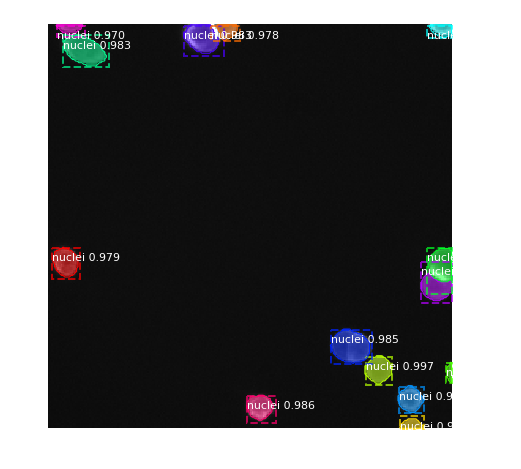

image  0  processed, bg type = bw 
id = 13ada12068b9d35f2a74ee5a9744b6091fa17eb737e72a48488b3b8e5c8afe97
image  1  processed, bg type = bw 
id = cbf1670753bb2b95ebb8f7b6a68e1238361c027f950275899c48f66b90c556d9
(5, 4)
(256, 256, 5)
(5,)
(5,)


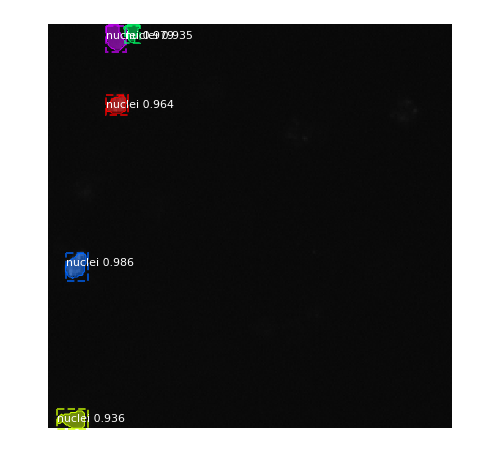

image  2  processed, bg type = bw 
id = a23bd67c0951c42d19342cdd6658b152952d265d32d8634c31a0cce1ed76af75
(133, 4)
(520, 696, 133)
(133,)
(133,)


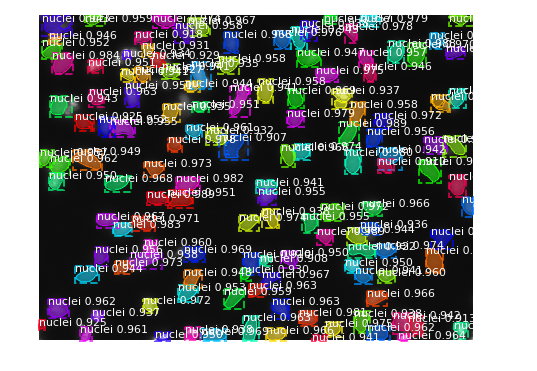

image  3  processed, bg type = bw 
id = 8842f82c1b98cb57046465393c4af55968a93995a5ad3cc20d28c415275ae87c
(1, 4)
(512, 512, 1)
(1,)
(1,)


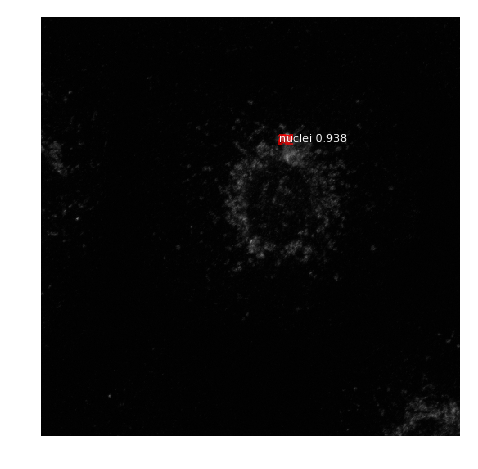

image  4  processed, bg type = bw 
id = 12e64a088a0c0c545de24786677383bfbe51ad5be5ab3812a1f38affb5694665
(7, 4)
(574, 574, 7)
(7,)
(7,)


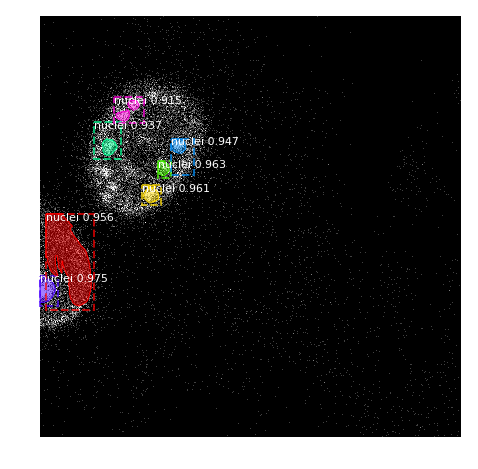

image  5  processed, bg type = bw 
id = 7de601fd01adf8779374fa9082421c4bc5e5b940fbc120f509660238cd4f8cc5
image  6  processed, bg type = bw 
id = 3256845310ed88c59805c285b46519848203263bbe7dce67c3f2a27e27b9c17e
(16, 4)
(256, 256, 16)
(16,)
(16,)


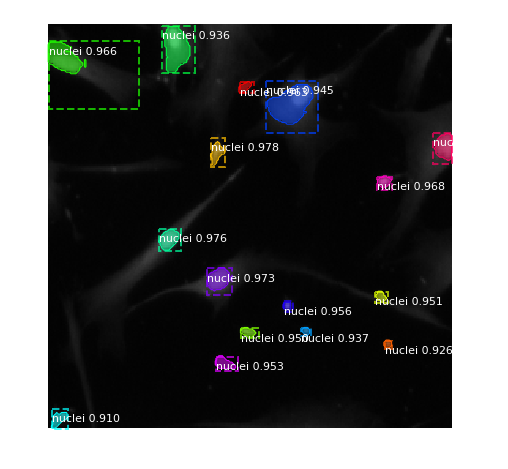

image  7  processed, bg type = bw 
id = bfe5d489404bf9228efe1a80763ca4f8cb9c2f8ca3ea6f3cbdb89fda64f8f450
(86, 4)
(520, 696, 86)
(86,)
(86,)


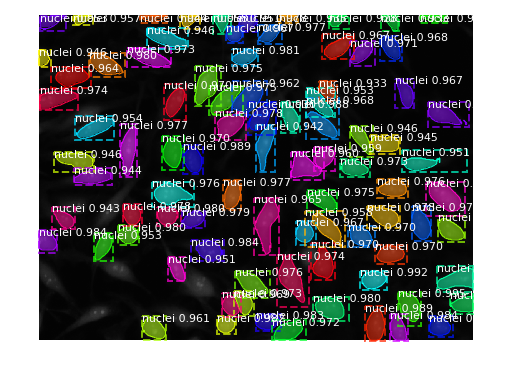

image  8  processed, bg type = bw 
id = b8284c831aa08dd5ede5fd89734045a297bd19559bae998f93ca01a1529abbed
image  9  processed, bg type = bw 
id = 2542a5402678b37129d9e55b541d716503d05018e988dcd859cafcc5a1a8eecf
(33, 4)
(256, 256, 33)
(33,)
(33,)


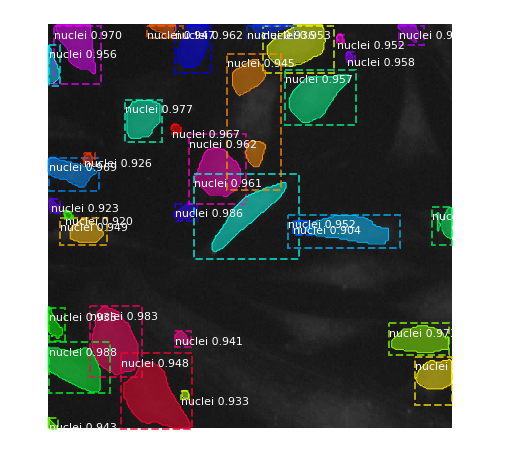

image  10  processed, bg type = bw 
id = 94f75d9ce083d08c25a0d7e2d6583c0aa4e2dfc0274b9d43806b9a3b5961d62e
(10, 4)
(256, 256, 10)
(10,)
(10,)


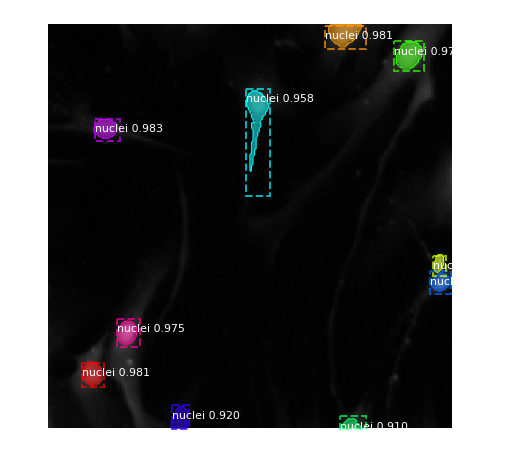

image  11  processed, bg type = bw 
id = 8313dab144d6cdba670db1ac439ca0721c20b6e7635ea3ad84132f62b077daec
(36, 4)
(512, 512, 36)
(36,)
(36,)


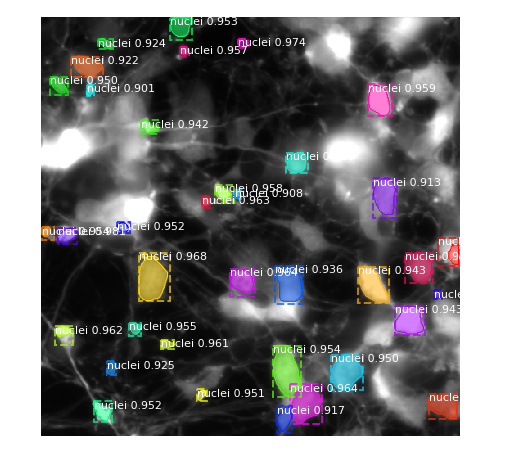

image  12  processed, bg type = bw 
id = 04301c58a7f4a4860dae496292661d09c2c5265ae4df3f7819eeae4a3d11f310
(2, 4)
(574, 574, 2)
(2,)
(2,)


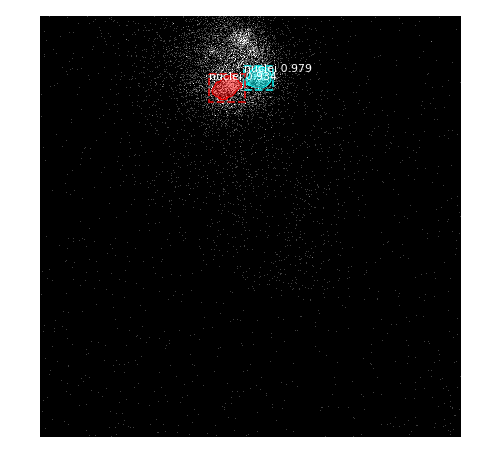

image  13  processed, bg type = bw 
id = 53096494bd15047a190acdae92f2322d1341c6f0da65b37d44aad873406a6f93
(4, 4)
(520, 694, 4)
(4,)
(4,)


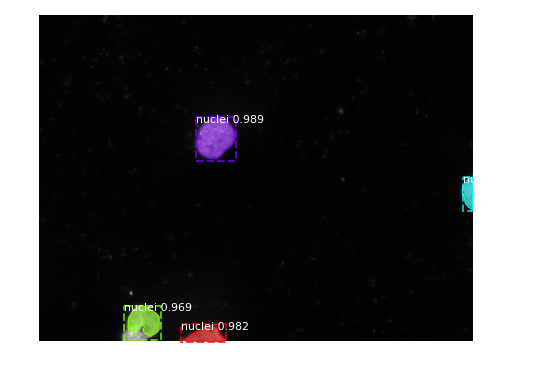

image  14  processed, bg type = bw 
id = c6e656c7886b251bbcf5624e2b7949c00664920b83f9cd26ec8cc0db3449876d
(9, 4)
(256, 256, 9)
(9,)
(9,)


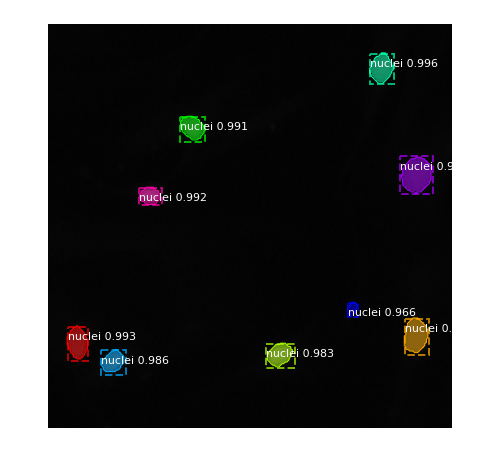

image  15  processed, bg type = bw 
id = 3885a5fd09669cf5fcf19fab18708197cf67aaaa971fa67fb1f86d44f047a87c
(11, 4)
(512, 512, 11)
(11,)
(11,)


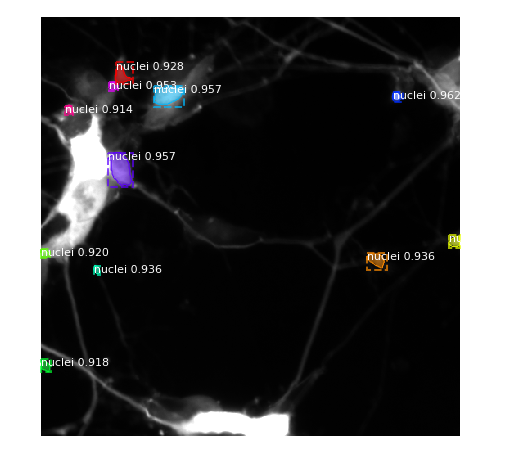

image  16  processed, bg type = bw 
id = 71ec3722b414ee0c037bd32bec8a431c375d7e65bae1f3d298a86497119804bc
(65, 4)
(520, 696, 65)
(65,)
(65,)


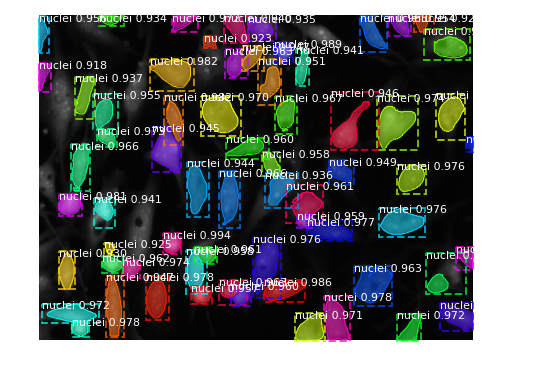

image  17  processed, bg type = bw 
id = 99f81f3624cd64fcecb0d755be75fbe93e82d0ee7c2f58de41fcb4bdf8dc1f04
(19, 4)
(256, 256, 19)
(19,)
(19,)


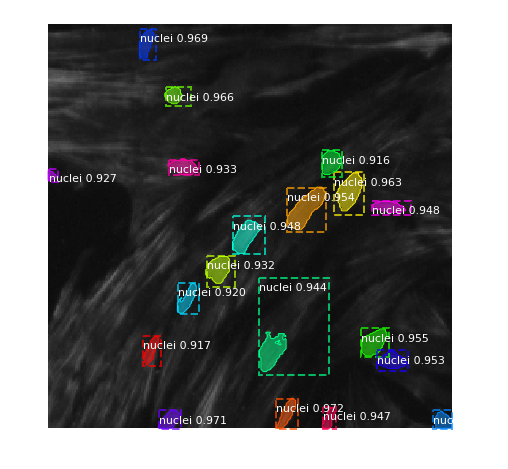

image  18  processed, bg type = bw 
id = fa3b20c9d7e20465d16cf6083f396bc062daf964419eaefae0bb24b71d5c2125
(22, 4)
(256, 256, 22)
(22,)
(22,)


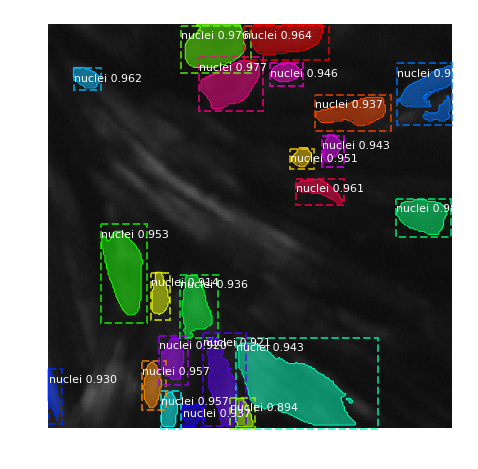

image  19  processed, bg type = bw 
id = aac373369991042f1e2ee4ae6a874f12e9ae9f4818ce623bd9094586b8bcdd63
(3, 4)
(414, 278, 3)
(3,)
(3,)


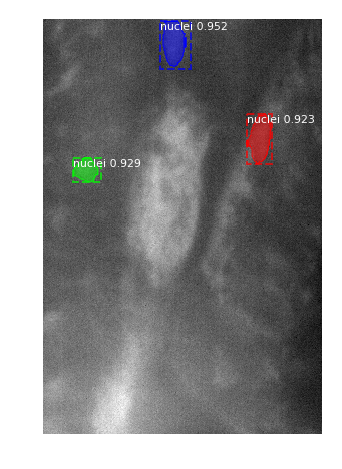

image  20  processed, bg type = bw 
id = 24405344807b6eed7aa34b333a6f931884dd08c0efd9af7a302a4a36cb0590a2
(4, 4)
(256, 256, 4)
(4,)
(4,)


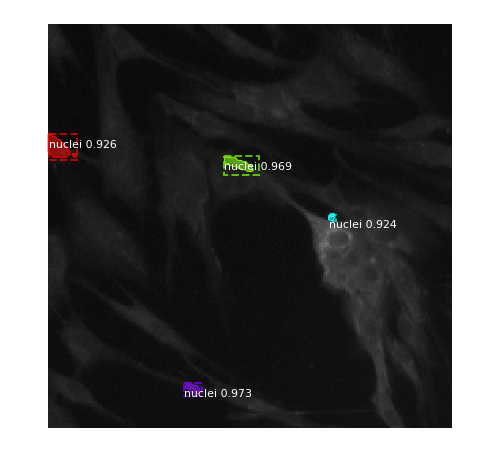

image  21  processed, bg type = bw 
id = f95b1128aea15019e4aafee22a07407f5b56c51ea483a5ce9d6968ab564f5c0d
(91, 4)
(520, 696, 91)
(91,)
(91,)


KeyboardInterrupt: 

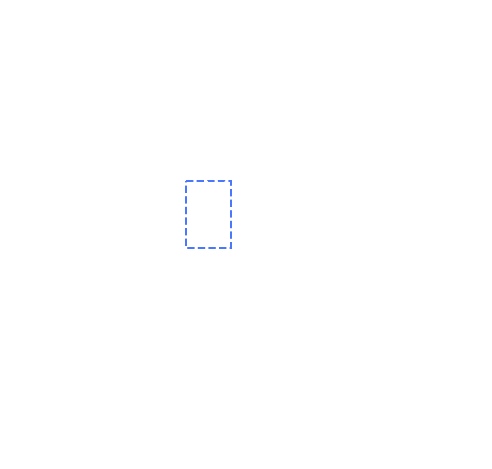

In [37]:
TESTING_BATCH_SIZE = 1000
TO_VISUALIZE =True
gen_index = 0
count = [0, 700]

for i in range(2):
    test_index = i
    dataset_test = test_datasets[test_index]
    
    processed_count = 0
    
    if test_index == gen_index:
        processed_count = count[0]
    else:
        continue
        
    while processed_count < len(dataset_test.image_ids) and processed_count < count[1]:
        print('processed_count =', processed_count)
        selected_test_ids = dataset_test.image_ids[processed_count:processed_count+TESTING_BATCH_SIZE]
        
        raw_predictions = []
        image_ids = []
        for x, test_id in enumerate(selected_test_ids):
            image_id = meta_test_groups[test_index].ImageId.values[x+processed_count]
            pred = ps.load_other_folder(image_id, '/ensemble') 
        
            if len(pred['scores']) > 0:
                new_masks = np.array(pred['masks'])
                boxes = np.array(pred['boxes'])
                scores = np.array(pred['scores'])
                class_ids = np.ones((len(pred['scores'],))).astype(np.uint8)

                #res[x]
                '''
                data = {
                   'boxes': res[i][0],
                   'masks': res[i][1],
                   'scores': res[i][2],
                   'class_ids': res[i][3],
                }
                filtered_boxes, filtered_masks, filtered_scores, filtered_class_ids, nb_filter_masks
                '''
                if TO_VISUALIZE is True and len(pred['boxes']) != 0:
                    test_image = dataset_test.load_image(test_id, 0)

                    print(boxes.shape)
                    print(new_masks.shape)
                    print(scores.shape)
                    print(class_ids.shape)

                    visualize.display_instances(test_image, boxes, new_masks, 
                                                class_ids, dataset_test.class_names, scores, ax=get_ax())

            print('image ', x+processed_count, 
                  ' processed, bg type =', meta_test_groups[test_index].bg_type.values[x+processed_count],
                  '\nid =', image_id)
            
            del pred; gc.collect()
        
        
        processed_count += len(selected_test_ids)